# Basic diffusion model

- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb#scrollTo=cAFFaVJ6tFbk
- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb#scrollTo=uCwLPv1CinQr
- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Number of samples: 60000
Number of batches: 7500
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 7, 3, 8, 9, 1, 0, 7])


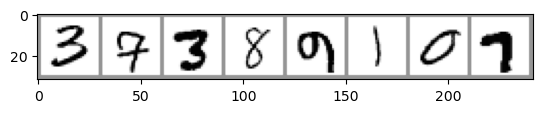

In [ ]:
# Load the dataset
dataset = torchvision.datasets.MNIST(
    root="data/",
    train=True, 
    download=True, 
    transform=T.Compose([
        T.ToTensor(),                 # [ 0, 1]
        T.Normalize((0.5,), (0.5,))   # [-1, 1]
    ])
)

print("Number of samples:", len(dataset))

# Feed it into a dataloader
train_dataloader = DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True
)

print("Number of batches:", len(train_dataloader))

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
plt.show()

Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:

$$
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I})$$

For noise $\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, 

$$
\mathbf{x}_t  = \sqrt{1 - \beta_t}\mathbf{x}_{t-1} + \sqrt{\beta_t}\boldsymbol\epsilon
$$

That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\sqrt{\beta_t}$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$$
\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I})
\end{aligned}
$$

where $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ and $\alpha_t = 1-\beta_t$.

For noise $\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$,

$$
\mathbf{x}_t  = \sqrt{\bar{\alpha}_t}\mathbf{x}_{0} + \sqrt{(1-\bar{\alpha}_t)}\boldsymbol\epsilon
$$

---
Training (`add_noise`)

$$
\mathbf{x}_0 \sim q(\mathbf{x_0})
$$

$$
t \sim \text{Uniform}({0,...,T-1})
$$

$$
\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

$$
\mathbf{x}_t  = \sqrt{\bar{\alpha}_t}\mathbf{x}_{0} + \sqrt{(1-\bar{\alpha}_t)}\epsilon
$$

$$
\text{Loss} = ||\boldsymbol\epsilon - \boldsymbol\epsilon_\theta(\mathbf{x}_t, t)||^2
$$

---
Sampling (`step`)

$$
\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

for $t=T-1, ..., 0$ do

$\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>0$, else $\mathbf{z}=\mathbf{0}$

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\boldsymbol\epsilon_\theta(\mathbf{x}_t, t) \right) + \sqrt{\beta_t}\mathbf{z}
$$
end for

return $\mathbf{x}_0$

In practice, define `Scheduler` which has methods `add_noise` and `step`.

---
Scheduler

1. `num_train_timesteps` $= T$
1. `timesteps` $= t = (0, 1, \cdots, T-1)$
1. `betas` $= \beta_t$
1. `alphas` $= \alpha_t = 1-\beta_t$
1. `alphas_cumprod` $= \bar{\alpha}_t = \prod_{s=1}^t \alpha_s$
1. `sqrt_alpha_prod` $= \sqrt{\bar{\alpha}_t}$
1. `sqrt_one_minus_alpha_prod` $= \sqrt{(1-\bar{\alpha}_t)}$

---
$\mathbf{x}_{t}$ = `add_noise`$(\mathbf{x}_0, \boldsymbol\epsilon, t)$

$\mathbf{x}_{t-1}$ = `step`$(\epsilon_\theta(\mathbf{x}_t, t), t, \mathbf{x}_{t})$

In [ ]:
class Scheduler:
    def __init__(
        self,
        num_train_timesteps = 1000,
        beta_start = 0.0001,
        beta_end = 0.02,
    ):
        self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        self.timesteps = torch.from_numpy(np.arange(0, num_train_timesteps)[::-1].copy())
    
    def add_noise(
        self,
        original_samples,
        noise,
        timesteps,
    ):
        self.alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device)
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device)
        timesteps = timesteps.to(device=original_samples.device)

        alphas_cumprod_t = alphas_cumprod[timesteps]

        # (bs, 1, 1, 1) 
        sqrt_alpha_prod = torch.sqrt(alphas_cumprod_t).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_prod = torch.sqrt(1.0 - alphas_cumprod_t).view(-1, 1, 1, 1)

        # (bs, 1, 1, 1)*(bs, c, h, w) + (bs, 1, 1, 1)*(bs, c, h, w)
        noisy_samples = sqrt_alpha_prod*original_samples + sqrt_one_minus_alpha_prod*noise
        return noisy_samples
    
    def step(
        self,
        model_output,
        timestep,
        sample,
    ):  
        sample = torch.clamp(sample, -1.0, 1.0)
        
        t = timestep
        current_alpha_t = self.alphas[t]
        current_beta_t = self.betas[t]
        current_alphas_cumprod_t = self.alphas_cumprod[t]

        z = torch.randn_like(sample) if t > 0 else 0.0

        fac1 = 1.0 / torch.sqrt(current_alpha_t)
        fac2 = current_beta_t / torch.sqrt(1.0 - current_alphas_cumprod_t)
        fac3 = torch.sqrt(current_beta_t)

        pred_prev_sample = fac1*(sample - fac2*model_output) + fac3*z
        return pred_prev_sample

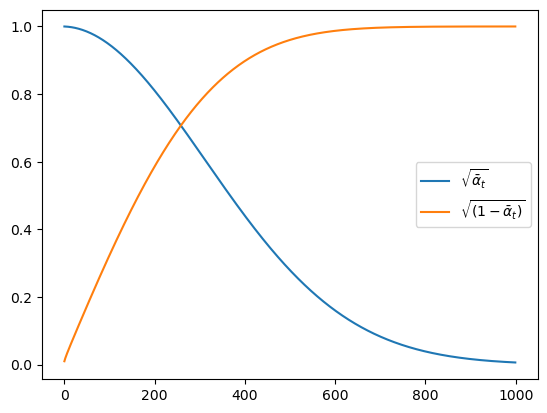

Timesteps: tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')
X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


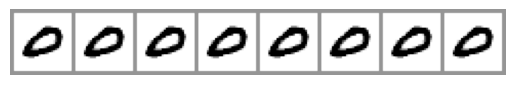

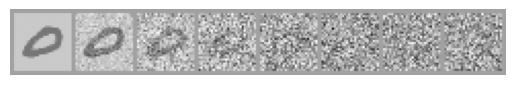

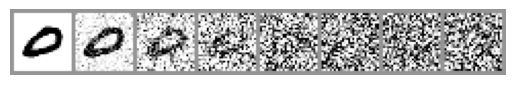

In [ ]:
noise_scheduler = Scheduler(num_train_timesteps=1000)

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend()
plt.show()

N = 8
timesteps = torch.linspace(0, 999, N).long().to(device)
print("Timesteps:", timesteps)

idx = torch.randint(0, len(dataset), (1,)).item()
xb = torch.stack([dataset[idx][0]]*N)
print("X shape", xb.shape)

noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

plt.figure()
plt.imshow(torchvision.utils.make_grid(xb)[0], cmap='Greys')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(torchvision.utils.make_grid(noisy_xb)[0], cmap='Greys')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(torchvision.utils.make_grid(torch.clamp(noisy_xb, -1, 1))[0], cmap='Greys')
plt.axis('off')
plt.show()

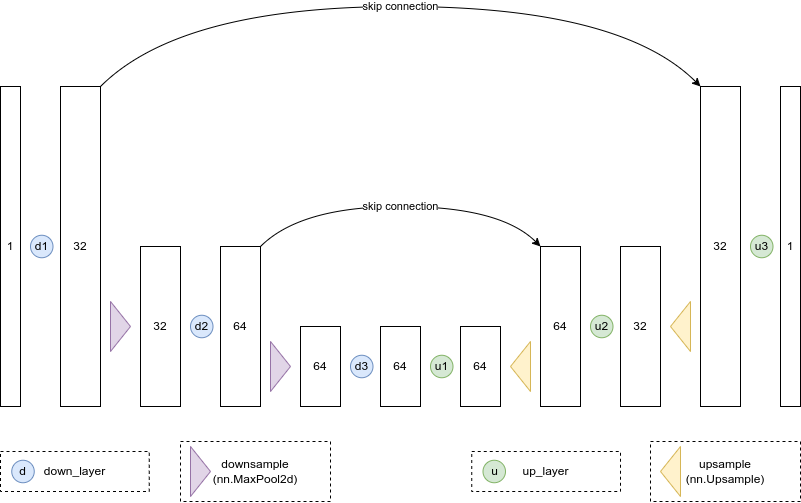

In [ ]:
class UNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, t):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
        
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

In [ ]:
net = UNet()
x, _ = next(iter(train_dataloader))
t = torch.randint(0, 1000, (8,)).long()
net(x, t).shape

torch.Size([8, 1, 28, 28])

In [ ]:
sum([p.numel() for p in net.parameters()])

309057

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average loss for this epoch: 0.439580


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average loss for this epoch: 0.402318


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average loss for this epoch: 0.393266


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average loss for this epoch: 0.387403


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average loss for this epoch: 0.379738


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average loss for this epoch: 0.374393


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average loss for this epoch: 0.370450


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average loss for this epoch: 0.367884


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average loss for this epoch: 0.364474


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average loss for this epoch: 0.362986


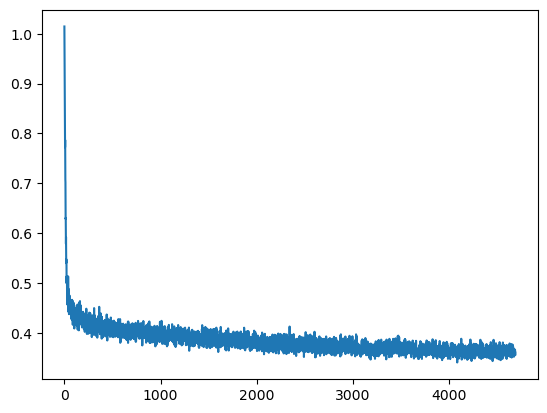

In [ ]:
# Noise scheduler
noise_scheduler = Scheduler(num_train_timesteps=1000)

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = UNet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, _ in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        x = x.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps) 

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

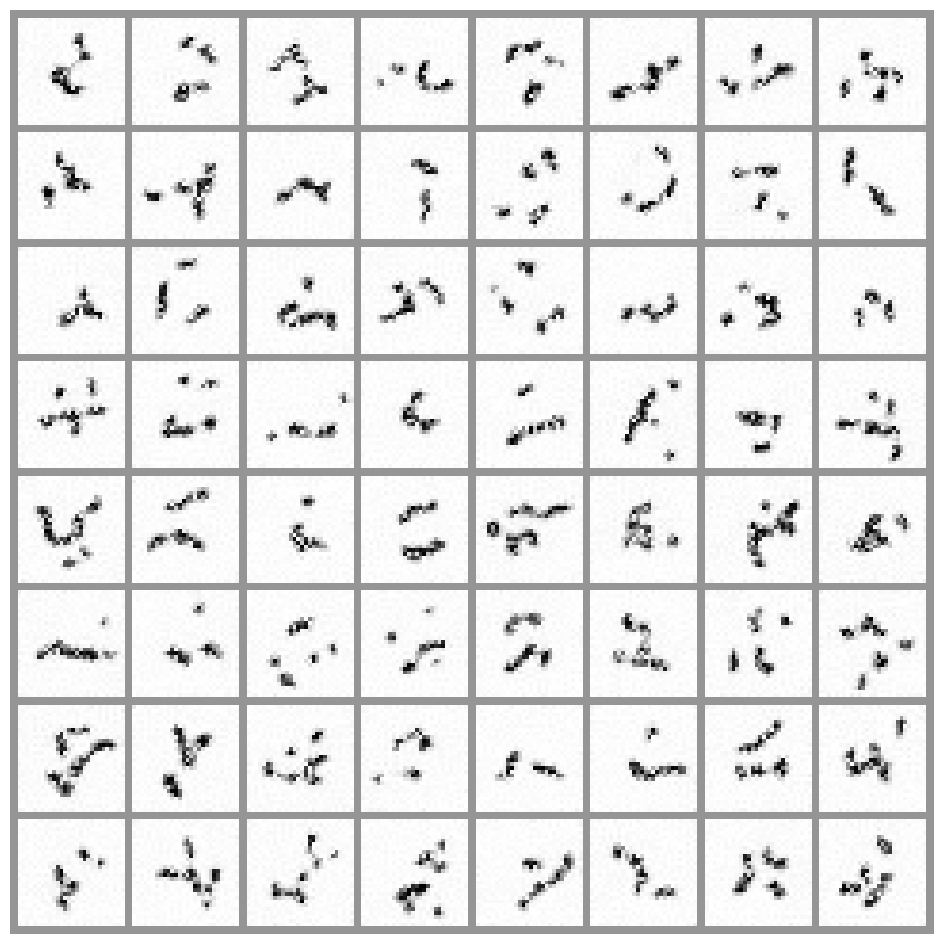

In [ ]:
# Noise scheduler for sampling
sample_scheduler = Scheduler(num_train_timesteps=1000)

# Prepare random x to start from
x = torch.randn(64, 1, 28, 28).to(device)

# Sampling loop
for t in tqdm(sample_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        model_output = net(x, t)

    # Update sample with step
    x = sample_scheduler.step(model_output, t, x)

# Show the results
plt.figure(figsize=(12, 12))
plt.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')
plt.axis('off')
plt.show()